# Import Libraries

In [1]:
import os

import pandas as pd
import numpy as np

from nltk.corpus import stopwords
from nltk import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decompositoin import PCA

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from translate import Translator

# functions which is special for this notebook
from string_operation import StringOperation

If the text is in **Indonesian**, a library called **Sastrawi** can be used.

# Functions

In [2]:
# see wordcloud
def generate_wordcloud(sentence_list, width=5, height=3):
    long_string = ','.join(sentence_list)# Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue'
                         )# Generate a word cloud
    wordcloud.generate(long_string)
    
    plt.figure(figsize=(width, height))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

# Read Dataset

In [3]:
input_path = os.path.join('dataset', 'scrapping_result.csv')
df_scrapping = pd.read_csv(input_path)
print(df_scrapping.shape)

display(df_scrapping)

(208, 5)


,page number,rank,domain,url,title
0,1,1,www.linux.org,https://www.linux.org/,Linux.org
1,1,2,id.wikipedia.org,https://id.wikipedia.org/wiki/Linux,"Linux - Wikipedia bahasa Indonesia, ensikloped..."
2,1,3,en.wikipedia.org,https://en.wikipedia.org/wiki/Linux,Linux - Wikipedia
3,1,4,tekno.kompas.com,https://tekno.kompas.com/read/2022/07/27/12150...,"Apa Itu Linux? Mengenal Fungsi, Sejarah, serta..."
4,1,5,diskominfo.kedirikab.go.id,https://diskominfo.kedirikab.go.id/baca/apa-it...,Apa itu Linux? - Kominfo Kab Kediri
...,...,...,...,...,...
203,22,204,lms.onnocenter.or.id,https://lms.onnocenter.or.id/wiki/index.php/OS...,OS: Linux Buatan Indonesia - OnnoWiki
204,22,205,www.techlila.com,https://www.techlila.com/id/introduction-linux...,Pengenalan Sistem Operasi Linux - TechLila
205,22,206,sevenmediatech.co.id,https://sevenmediatech.co.id/blog/view/web-dev...,Web Developer Pilih Windows atau Linux
206,22,207,mahasiswa.ung.ac.id,https://mahasiswa.ung.ac.id/532413025/home/201...,PROGRAM IT TENTANG SISTEM OPERASI LINUX


# Simple Profiling

there will be no visualization

In [4]:
# check profile and missing value
print(df_scrapping.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   page number  208 non-null    int64 
 1   rank         208 non-null    int64 
 2   domain       208 non-null    object
 3   url          208 non-null    object
 4   title        208 non-null    object
dtypes: int64(2), object(3)
memory usage: 8.2+ KB
None


there is no missing value

In [5]:
# check domain website that is shown more than one
print('unique domain website:', df_scrapping['domain'].nunique())

webdomain_count = df_scrapping['domain'].value_counts().to_frame()
webdomain_count.columns = ['count']
webdomain_count.index.name = 'domain web'
webdomain_count = webdomain_count[webdomain_count['count']>1]

display(webdomain_count)

print(f'domain web with the most content is {webdomain_count.index[0]}')

unique domain website: 175


,count
domain web,
www.youtube.com,4
www.gentoo.org,3
www.pilarteknotama.co.id,3
linux.softpedia.com,2
www.jenkins.io,2
www.edx.org,2
voidlinux.org,2
learn.microsoft.com,2
www.geeksforgeeks.org,2


domain web with the most content is www.youtube.com


In [6]:
# website domain more than one data with respective content rank and page
wdomain_count_wrank = (df_scrapping.groupby(['domain'])
      .agg({'rank': lambda x: x.tolist(), 'page number': lambda x: x.tolist()})
      )
wdomain_count_wrank.index.name = 'domain web'

# merge data with domain count
wdomain_merge = webdomain_count.merge(wdomain_count_wrank, on='domain web',
                                     how='left')
# sort values by rank
wdomain_merge.sort_values(by=['rank'], inplace=True)
display(wdomain_merge)

print(f'''the number domain web with more than 1 content is {wdomain_merge.index[0]}\
with rank {wdomain_merge.iloc[0, 1]} in page {wdomain_merge.iloc[0, 2]}''')

,count,rank,page number
domain web,,,
www.linux.com,2,"[13, 14]","[2, 2]"
www.niagahoster.co.id,2,"[17, 18]","[2, 2]"
shopee.co.id,2,"[22, 38]","[3, 5]"
learn.microsoft.com,2,"[27, 29]","[3, 4]"
www.redhat.com,2,"[39, 46]","[5, 6]"
brave.com,2,"[51, 61]","[7, 8]"
linux.softpedia.com,2,"[54, 63]","[7, 8]"
www.home-assistant.io,2,"[55, 68]","[7, 8]"
kodi.tv,2,"[56, 62]","[7, 8]"


the number domain web with more than 1 content is www.linux.comwith rank [13, 14] in page [2, 2]


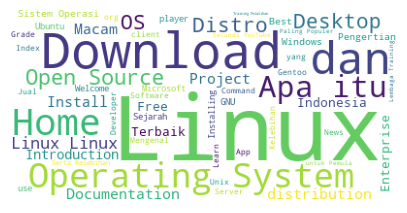

In [7]:
# see englisht title wordcloud
generate_wordcloud(list(df_scrapping['english title'].values))

The data contains more than one (Indonesia and English), so the Indonesian will be translated first into English in the next step

# Preprocess

Column **english title** will be used in the next processing

In [8]:
# remove linux from sentence because it is the main topic from search result
stopword_list = stopwords.words('english') + ['linux']

In [9]:
df_preprocess = df_scrapping.copy()

# remove nonalphabetic data
df_preprocess['clean_title'] = StringOperation.remove_nonalphabet(df_preprocess['title'])
# remove stopwords
df_preprocess['clean_title'] = StringOperation.remove_stopwords(df_preprocess['clean_title'], )
# word stemming
df_preprocess['clean_title'] = StringOperation.word_stemming(df_preprocess['clean_title'])

display(df_preprocess)

KeyboardInterrupt: 

In [ ]:
generate_wordcloud(list(df_preprocess['clean_title'].values))

now there is only one language in the dataset shown from the picture above

# Clustering Section

clustering process be evaluated using **silhouette score**

In [ ]:
# create model for text data
vectorizer = TfidfVectorizer(
    tokenizer = word_tokenize,
    max_df = 0.8,
    min_df = 3,
    max_features=100,
    ngram_range=(1,3)
)
tfidf_model = vectorizer.fit_transform(df_preprocess['clean_title'])

In [ ]:
# define range cluster to ve evaluated
max_cluster = 21
cluster_range = range(2,max_cluster)

result_score = {}

for cluster_ in cluster_range:
    km_model = KMeans(n_clusters=cluster_, random_state=42, n_init=1)
    km_model.fit_predict(tfidf_model)
    
    score = silhouette_score(tfidf_model, km_model.labels_, metric='euclidean')
    # Print the score
    print(f'Silhouetter Score for {cluster_}: %.3f' % score)
    
    # save result
    result_score[cluster_] = score

In [ ]:
max(list(result_score.values()))

In [ ]:
feature_names = vectorizer.get_feature_names()

dense = tfidf_model.todense()
denselist = dense.tolist()

all_keywords = []

for description in denselist:
    x=0
    keywords = []
    for word in description:
        if word > 0:
            keywords.append(feature_names[x])
        x=x+1
    all_keywords.append(keywords)


In [ ]:
print (df_preprocess['clean_title'][0])
print (all_keywords[0])